In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import itertools
import time
import random
import ast

In [2]:
# Utils & Functions
from utils import *
from hrga import *
from tndp import *
from export import *
from plot import *

### Graph Structure for Instance 2 (Toy 2 Instance)

Example taken from Guan et al. (2006). 9-node network used as case study. In this case there are multiple paths for some of the origin-destination pairs. This configuration leads to a more complicated line configuration.

In [3]:
# Generating Mandl's Network

# Create graph
G = nx.Graph()

# Node Positions
node_positions = [(-2, 0), (-2, -1), (-1, 0), (0, 0), (0, -1), (1, 0), (1, -1), (2, 0), (2, -1)]

# Add nodes
for i in range(9):
    G.add_node(i+1, pos=node_positions[i])
    

    
# Add edges
edge_list =    [(1, 3), (2, 3), (3, 4), (3, 5), (4, 5), (4, 6), (5, 7), (6, 7), (6, 8), (7, 9)]
edge_lengths = [  4010,  21580,   6051,   9272,   5554,  11776,   5242,   4331,   5246,   6226]
edge_times =   [     7,     15,     12,     11,     11,     23,     11,      8,      9,     11]

for i in range(len(edge_list)):
    G.add_edge(*edge_list[i], length=edge_lengths[i], travel_time=edge_times[i])

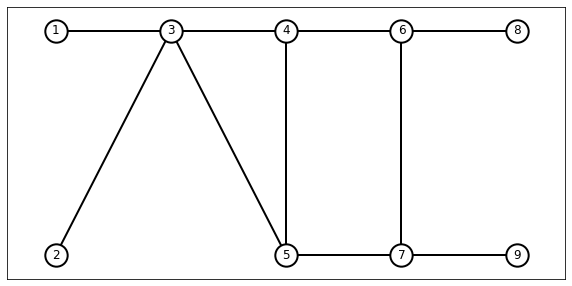

In [4]:
# Plot Graph
f, ax = plt.subplots(figsize=(10, 5))

pos = nx.get_node_attributes(G, 'pos')

node_plot = nx.draw_networkx_nodes(G, pos, node_color='white', node_size=500)
edges_plot = nx.draw_networkx_edges(G, pos, width=2)
labels_plot = nx.draw_networkx_labels(G, pos)

# Change border
node_plot.set_edgecolor('k')
node_plot.set_linewidth(2)

# Display
plt.show()

#### Generating All Possible Routes

Generate all possible routes by enumerating shortest paths from any origin $i$ to any destination $j$. Since this is a small network, we generate all simple paths with no problem. Note that a single path can be found in $O(N+E)$ time, but the number of simple paths can be large $O(n!)$. A simple path is a path with no repeated nodes.

In [6]:
# Initialize List
routes = []

# Iterate
for origin in list(G.nodes()):
    for destination in list(G.nodes()):
        
        # If origin is not destination...
        if origin != destination:
            
            # Iterate paths
            for route in list(nx.shortest_simple_paths(G, origin, destination, weight='length')):
                routes.append(route)

In [7]:
print(f'Number of feasible routes (before removing simetrical routes): {len(routes)}')

Number of feasible routes (before removing simetrical routes): 220


In [8]:
# Apply function (tndp.py)
unique = unique_routes(routes)
print(f'Number of feasible routes (after removing simetrical routes): {len(unique)}')

Number of feasible routes (after removing simetrical routes): 110


#### Generate Demand Matrix

Generate a demand matrix for all OD pairs. Since demand data is not available from Guan et al. (2006), we generate a random matrix with demands ranging from 0 to 9. A seed is declared so results are reproducible.

In [9]:
# Random Seed
np.random.seed(123456)

# Generate random demand matrix
demand_matrix = (np.random.rand(len(G.nodes()), len(G.nodes())) * 10).astype(np.int32)

for i in range(demand_matrix.shape[0]):
    demand_matrix[i][i] = 0

# Print Matrix
print(demand_matrix)

[[0 9 2 8 3 3 4 8 1]
 [5 0 4 1 8 8 3 2 7]
 [5 1 0 2 1 5 5 0 5]
 [2 3 9 0 0 8 7 4 3]
 [1 3 6 2 0 8 4 6 1]
 [7 4 3 5 1 0 7 0 4]
 [0 4 8 8 7 7 0 4 1]
 [0 9 1 6 6 4 1 0 6]
 [0 5 1 4 8 1 3 6 0]]


#### Generate $\Delta$ Matrix

Generate $\Delta_{er}$ matrix. This matrix tells if edge $e \in E$ is part of route $r \in R$.

In [10]:
DELTA = generate_DELTA_matrix(G, routes)
print(f'DELTA Matrix: \n')
print(DELTA)

DELTA Matrix: 

[[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 1 1]
 [0 0 1 ... 0 1 1]]


#### Enumerate Paths

Since we are working with a small instance we are going to enumerate all possible paths from all origins and all destinations. This instance allows for multiple paths in some cases, for that we calculate the $k$ shortest paths. Given a large enough $k$ we expect for all possible paths to be calculated. This approach would be unfeasible in larger networks, however.

Since we calculated routes using all possible paths, the set of possible paths is identical to the set of routes.

In [11]:
# Generate OD Pairs List
od_pairs = generate_od_pair_list(G, demand_matrix)

In [12]:
# Generate Paths
paths, num_paths = generate_paths(G, od_pairs)

#### Generate $\delta$ Tensor

The $\delta_{ep}^{od}$ tensor indicates if the edge $e$ is used on path $p$ chosen from origin $o$ to destination $d$. It allows for the coupling of routes and paths in the optimization model.

This matrix has shape $[od][k][e]$

In [13]:
# Generate Matrix
delta = generate_delta_matrix(G, od_pairs, num_paths, paths)
#delta

#### Generate Outputs

In [14]:
# Nodes
node_ids = list(G.nodes())
node_x = [G.nodes[node]['pos'][0] for node in G.nodes()]
node_y = [G.nodes[node]['pos'][1] for node in G.nodes()]


# Data
node_data = {
    'id' : node_ids,
    'x' : node_x,
    'y' : node_y,
}

# Dataframe
nodes_df = pd.DataFrame(data=node_data)

# Print
#nodes_df

In [15]:
# Edges
edge_ids = [id + 1  for id in range(len(G.edges()))]
edge_origins = [u for u, v in G.edges()]
edge_destinations = [v for u, v in G.edges()]
edge_lengths = [G[u][v]['length'] for u, v in G.edges()]
edge_travel_time = [G[u][v]['length'] for u, v in G.edges()]
edge_capacity = [10 for edge in range(len(G.edges()))]

# Data
edge_data = {
    'id' : edge_ids,
    'origin' : edge_origins,
    'destination' : edge_destinations,
    'length' : edge_lengths,
    'travel_time' : edge_travel_time,
    'capacity' : edge_capacity
}

# Dataframe
edges_df = pd.DataFrame(data=edge_data)

# Print
#edges_df

In [16]:
# OD Matrix
od_ids = [id + 1 for id in range(len(od_pairs))]
od_origin = [int(od.split('-')[0]) for od in od_pairs]
od_destination = [int(od.split('-')[1]) for od in od_pairs]
od_demand = [demand_matrix[int(od.split('-')[0]) - 1][int(od.split('-')[1]) - 1] for od in od_pairs]
od_paths = [num_paths[od] for od in od_pairs]

# Data
od_data = {
    'id' : od_ids,
    'origin' : od_origin,
    'destination' : od_destination,
    'demand' : od_demand,
    'paths' : od_paths
}

# Dataframe
od_df = pd.DataFrame(data=od_data)
#od_df

In [17]:
# Routes
route_ids = [id + 1 for id in range(len(routes))]
route_sequences = [str(sequence) for sequence in routes]
route_length = [nx.path_weight(G, route, weight='length') for route in routes]
route_stops = [len(route) for route in routes]

# Data
route_data = {
    'id' : route_ids,
    'sequence' : route_sequences,
    'length' : route_length,
    'num_stops' : route_stops
}

route_df = pd.DataFrame(data=route_data)
#route_df

In [18]:
k = 10

# Paths
paths_id = [id + 1 for id in range(len(paths) * k)]
paths_sequence = [str(paths[od][i]) if i < len(paths[od]) else '' for od in paths for i in range(k)]
paths_length = [nx.path_weight(G, paths[od][i], weight='length') if i < len(paths[od]) else 0 for od in paths for i in range(k)]
paths_stops = [len(paths[od][i]) if i < len(paths[od]) else 0 for od in paths for i in range(k)]

# Data
paths_data = {
    'id' : paths_id,
    'sequence' : paths_sequence,
    'length' : paths_length,
    'num_stops' : paths_stops
}

paths_df = pd.DataFrame(data=paths_data)
#paths_df

In [19]:
# DELTA Matrix
DELTA_value = [edge for route in DELTA for edge in route]
edge_ids = [id + 1 for id in range(len(G.edges()))] * len(routes)
route_ids = [id + 1 for id in range(len(routes)) for i in range(len(G.edges()))]

# Data
DELTA_data = {
    'route_id' : route_ids,
    'edge_id' : edge_ids,    
    'DELTA' : DELTA_value
}

# Dataframe
DELTA_df = pd.DataFrame(data=DELTA_data)
#DELTA_df

In [20]:
k = 10

# delta Matrix
delta_value = [edge for od in delta for path in od for edge in path]
od_ids = [id + 1 for id in range(len(od_pairs)) for i in range(k) for j in range(len(G.edges()))]
path_ids = [id + 1 for id in range(k) for edge in range(len(G.edges()))] * len(od_pairs)
edge_ids = [id + 1 for id in range(len(G.edges()))] * k * len(od_pairs)

od_origins = [int(od_pairs[id].split('-')[0]) for id in range(len(od_pairs)) for i in range(k) for j in range(len(G.edges()))]
od_destinations = [int(od_pairs[id].split('-')[1]) for id in range(len(od_pairs)) for i in range(k) for j in range(len(G.edges()))]

# Data
delta_data = {
    'od' : od_ids,
    'path' : path_ids,
    'edge' : edge_ids,
    'delta' : delta_value,
    'origin' : od_origins,
    'destination' : od_destinations
}

# DataFrame
delta_df = pd.DataFrame(data=delta_data)
#delta_df

#### Preprocess Y Variable

In [21]:
# Vectors
y_fix_od = []
y_fix_r  = []

# Iterate over OD pairs
for i, row in od_df.iterrows():
    
    # Iterate over routes
    for i, route in enumerate(routes):
        
        # If neither origin, nor destination in route, add do vector
        if (row['origin'] not in route) and (row['destination'] not in route):
            
            y_fix_od.append(row['id'])
            y_fix_r.append(i+1)
            
# Print Results
print(f'y_od_r original size: {od_df.shape[0] * len(routes)}')
print(f'fixed_variables: {len(y_fix_od)}')
print(f'y_od_r simplified size: {(od_df.shape[0] * len(routes)) - len(y_fix_od)}')

y_od_r original size: 7260
fixed_variables: 1736
y_od_r simplified size: 5524


#### Reduce Dimensionality of $\delta$ Matrix

In [22]:
# Initialize W Vector
od_path_edge = []
start_index  = []
finish_index = []

# Counter
i = 0

# Rename edges_df
df = edges_df

# Iterate over OD pairs
for j, od in enumerate(od_pairs):
    
    i += 1
    
    if j % 100 == 0:
        print(f'iterating over od pair {j+1}/{len(od_pairs)}' )
    
    # Iterate over paths
    for k in range(10):# enumerate(paths[od]):

        # If index in range
        if k < len(paths[od]):
           
            # Convert path to edges
            edges_path = path_nodes_to_edges(paths[od][k])

            # Add Starting Index
            start_index.append(i)

            # I
            i += len(edges_path) - 1

            # Add Ending Index
            finish_index.append(i)
            
            # I
            #i += 1 

            # Iterate over edges
            for edge in edges_path:

                # Find edge id
                edge_id = df[((df.origin == edge[0]) & (df.destination == edge[1])) | ((df.origin == edge[1]) & (df.destination == edge[0]))].id.values[0]

                # Add id to list
                od_path_edge.append(edge_id)            
        
        # If out of range...
        else:
            
            # Add Starting Index
            start_index.append(i)

            # Add Ending Index
            finish_index.append(i)

iterating over od pair 1/66


In [23]:
print(f'Length of vector: {len(od_path_edge)}')

Length of vector: 685


In [24]:
k = 10

# delta Matrix
od_ids = [id + 1 for id in range(len(od_pairs)) for i in range(k)]
path_ids = [id + 1 for id in range(k)] * len(od_pairs)
path_size = [len(paths[od][i]) if i < len(paths[od]) else 0 for od in od_pairs for i in range(k)]
od_origins = [int(od_pairs[id].split('-')[0]) for id in range(len(od_pairs)) for i in range(k)]
od_destinations = [int(od_pairs[id].split('-')[1]) for id in range(len(od_pairs)) for i in range(k)]


# Data
reduced_delta_data = {
    'od' : od_ids,
    'path' : path_ids,
    'path_size' : path_size,
    'w_start' : start_index,
    'w_finish' : finish_index,
    'origin' : od_origins,
    'destination' : od_destinations
}

# DataFrame
reduced_delta_df = pd.DataFrame(data=reduced_delta_data)
#reduced_delta_df

In [25]:
orig = delta_df.shape[0]
redu = len(od_path_edge)

print(f'Expected Reduction in Dimensionality: from {orig} elements to {redu} elements. A {((1 - (redu/orig)) * 100):.2f} % reduction')

Expected Reduction in Dimensionality: from 6600 elements to 685 elements. A 89.62 % reduction


#### Reduce Dimensionality of $\Delta$ Matrix

In [26]:
# Initialize Vectors
route_list = []

edge_list = []
start_pos = []
end_pos = []

# Initialize Counter
e_start = 0

# Iterate over edges
for i, edge in enumerate(list(G.edges())):
    
    # Add 1
    #e_start += 1
    
    # Append Data
    edge_list.append(i+1)
    start_pos.append(e_start+1)
    
    # Iterate over routes
    for route in routes:
    
        # Transform route from nodes to edges
        route_edges = path_nodes_to_edges(route)

        # If edge in route
        if (edge in route_edges) or (edge[::-1] in route_edges):
            
            # Add 1 to counter
            e_start += 1
            
            # Find route ID
            route_id = route_df[route_df.sequence == str(route)].id.values[0]

            # Append Data
            route_list.append(route_id)
            
            
    
    # Append Finish
    end_pos.append(e_start)

In [27]:
len(route_list)

382

In [ ]:
# CSVs
# nodes_df.to_csv('exports/instance_02/nodes.csv', index=False, sep=',')
# edges_df.to_csv('exports/instance_02/edges.csv', index=False, sep=',')
# od_df.to_csv('exports/instance_02/od_matrix.csv', index=False, sep=',')
# DELTA_df.to_csv('exports/instance_02/big_delta.csv', index=False, sep=',')
# delta_df.to_csv('exports/instance_02/small_delta.csv', index=False, sep=',')
# route_df.to_csv('exports/instance_02/routes.csv', index=False, sep=',')
# paths_df.to_csv('exports/instance_02/paths.csv', index=False, sep=',')

### Manual Array Initialization

In [29]:
instance = 'instance_02'

In [30]:
sizes = [len(G.nodes()), len(G.edges()), len(od_pairs), len(routes), k, len(od_path_edge), len(route_list), len(y_fix_od)] 

print(f'OD Pairs  = {len(od_pairs)}')
print(f'Routes    = {len(routes)}')
print(f'Nodes     = {len(G.nodes())}')
print(f'Edges     = {len(G.edges())}')
print(f'Max_Paths = {k}')

OD Pairs  = 66
Routes    = 110
Nodes     = 9
Edges     = 10
Max_Paths = 10


In [ ]:
# return_xpress_int_txt(sizes, filename=f'exports/{instance}/array_sizes.txt')

**Node Data**

In [ ]:
# return_xpress_int_txt(nodes_df.id, filename=f'exports/{instance}/node_id.txt')
# return_xpress_str_txt(nodes_df.id, filename=f'exports/{instance}/node_name.txt')

**Edge Data**

In [47]:
uv = list(edges_df.origin.values) + list(edges_df.destination.values)

In [ ]:
# return_xpress_int_txt(edges_df.id, filename=f'exports/{instance}/edge_id.txt')
# return_xpress_int_txt(uv, filename=f'exports/{instance}/edge_uv.txt')
# return_xpress_int_txt(edges_df.length, filename=f'exports/{instance}/edge_length.txt')
# return_xpress_int_txt(edges_df.travel_time, filename=f'exports/{instance}/edge_time.txt')
# return_xpress_int_txt(edges_df.capacity, filename=f'exports/{instance}/edge_capacity.txt')

**OD Matrix Data**

In [ ]:
# return_xpress_int_txt(od_df.origin, filename=f'exports/{instance}/origins.txt')
# return_xpress_int_txt(od_df.destination, filename=f'exports/{instance}/destinations.txt')
# return_xpress_int_txt(od_df.demand, filename=f'exports/{instance}/demand.txt')

**Routes**

In [ ]:
frequencies = [1 for route in routes]

In [ ]:
# return_xpress_str_txt(route_df.sequence.values, filename=f'exports/{instance}/route_sequence.txt')
# return_xpress_int_txt(route_df.length.values, filename=f'exports/{instance}/route_length.txt')
# return_xpress_int_txt(frequencies, filename=f'exports/{instance}/route_frequency.txt')

**Paths**

In [ ]:
# return_xpress_str_txt(paths_df.sequence.values, filename=f'exports/{instance}/path_sequence.txt')
# return_xpress_int_txt(paths_df.length, filename=f'exports/{instance}/path_length.txt')

**Y Preprocessing**

In [ ]:
# return_xpress_int_txt(y_fix_od, filename=f'exports/{instance}/yfix_origin_destination.txt')
# return_xpress_int_txt(y_fix_r, filename=f'exports/{instance}/yfix_routes.txt')

**$\delta$ Dimensionality Redux**

In [ ]:
# return_xpress_int_txt(od_path_edge, filename=f'exports/{instance}/small_delta.txt')
# return_xpress_int_txt(reduced_delta_df.w_start, filename=f'exports/{instance}/small_delta_start.txt')
# return_xpress_int_txt(reduced_delta_df.w_finish, filename=f'exports/{instance}/small_delta_finish.txt')

**$\Delta$ Dimensionality Redux**

In [ ]:
# return_xpress_int_txt(route_list, filename=f'exports/{instance}/big_delta.txt')
# return_xpress_int_txt(start_pos, filename=f'exports/{instance}/big_delta_start.txt')
# return_xpress_int_txt(end_pos, filename=f'exports/{instance}/big_delta_finish.txt')